# Introduction

#### Imports

Imports and settings.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from impyute.imputation.cs import fast_knn

pd.options.mode.chained_assignment = None

# Table of Content

1. [Summary information](#summ)
2. [Data preprocessing](#prep)
3. [Exploratory data analysis](#eda)
4. [Prediction](#pred)
5. [Evaluation](#eval)
6. [Conclusion](#conc)

## 1. Summary information
<a id="summ"></a>

In [2]:
train = pd.read_csv('datasets/train_set.csv')
test = pd.read_csv('datasets/test_set.csv')

In [3]:
train.head(2)

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
0,9.767406e+10,134520.0,70.0,2.0,1199.0,77.0,4.0,861.0,17.550,81.64,18.0,0
1,9.768889e+10,133876.0,67.0,3.0,12585.0,90.0,4.0,4371.0,17.383,189.38,28.0,4


In [4]:
test.head(2)

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent
0,14942256073,122750.0,58.0,2.0,11503.0,89.0,0.0,168.0,13.500,90.19,32.0
1,16036037903,28134.0,68.0,4.0,938.0,81.0,5.0,735.0,13.667,98.27,19.0


In [5]:
print('Number train entries:', len(train), ', Number test entries:', len(test))

Number train entries: 396487 , Number test entries: 132162


In [ ]:
train_columns = ['hotel_id', 'city_id', 'content_score', 'n_images', 'distnace_to_center', 'avg_rating', 'stars', 'n_reviews', 'avg_rank', 'avg_price', 'avg_saving_percent', 'n_clicks']

In [6]:
print('train column names and types:', train.dtypes, sep='\n')
print('-'*28)
print('test column names and types:', test.dtypes, sep='\n')

train column names and types:
hotel_id              float64
city_id               float64
content_score         float64
n_images              float64
distance_to_center    float64
avg_rating            float64
stars                 float64
n_reviews             float64
avg_rank              float64
avg_price             float64
avg_saving_percent    float64
n_clicks                int64
dtype: object
----------------------------
test column names and types:
hotel_id                int64
city_id               float64
content_score         float64
n_images              float64
distance_to_center    float64
avg_rating            float64
stars                 float64
n_reviews             float64
avg_rank              float64
avg_price             float64
avg_saving_percent    float64
dtype: object


In [7]:
print('Train data set:  \n\n{0}\n'.format(train.count()))
print('-'*28)
print('Test data set:  \n\n{0}\n'.format(test.count()))

Train data set:  

hotel_id              396487
city_id               395979
content_score         395979
n_images              395978
distance_to_center    395958
avg_rating            286089
stars                 395925
n_reviews             395958
avg_rank              396487
avg_price             396317
avg_saving_percent    396317
n_clicks              396487
dtype: int64

----------------------------
Test data set:  

hotel_id              132162
city_id               132007
content_score         132007
n_images              132006
distance_to_center    131999
avg_rating             95532
stars                 131987
n_reviews             131999
avg_rank              132162
avg_price             132104
avg_saving_percent    132104
dtype: int64



In [8]:
train_columns = list(train.columns)
print('Train data set:\n')
for column in train_columns:
    print('All entries in train set have non-null', column ,':', ~train[column].isnull().any())
    
print('-'*100)

test_columns = list(test.columns)
print('Test data set:\n')
for column in test_columns:
    print('All entries in test set have non-null', column ,':', ~test[column].isnull().any())

Train data set:

All entries in train set have non-null hotel_id : True
All entries in train set have non-null city_id : False
All entries in train set have non-null content_score : False
All entries in train set have non-null n_images : False
All entries in train set have non-null distance_to_center : False
All entries in train set have non-null avg_rating : False
All entries in train set have non-null stars : False
All entries in train set have non-null n_reviews : False
All entries in train set have non-null avg_rank : True
All entries in train set have non-null avg_price : False
All entries in train set have non-null avg_saving_percent : False
All entries in train set have non-null n_clicks : True
----------------------------------------------------------------------------------------------------
Test data set:

All entries in test set have non-null hotel_id : True
All entries in test set have non-null city_id : False
All entries in test set have non-null content_score : False
All 

In [9]:
print("Train data set:\n")
for column in train_columns:
    print('Percentage of missing values for feature', column ,':', round((train[column].isnull().sum()/len(train))*100, 2), '%')
print("-"*100)
print("Test data set:\n")
for column in test_columns:
    print('Percentage of missing values for feature', column ,':', round((test[column].isnull().sum()/len(test))*100, 2), '%')

Train data set:

Percentage of missing values for feature hotel_id : 0.0 %
Percentage of missing values for feature city_id : 0.13 %
Percentage of missing values for feature content_score : 0.13 %
Percentage of missing values for feature n_images : 0.13 %
Percentage of missing values for feature distance_to_center : 0.13 %
Percentage of missing values for feature avg_rating : 27.84 %
Percentage of missing values for feature stars : 0.14 %
Percentage of missing values for feature n_reviews : 0.13 %
Percentage of missing values for feature avg_rank : 0.0 %
Percentage of missing values for feature avg_price : 0.04 %
Percentage of missing values for feature avg_saving_percent : 0.04 %
Percentage of missing values for feature n_clicks : 0.0 %
----------------------------------------------------------------------------------------------------
Test data set:

Percentage of missing values for feature hotel_id : 0.0 %
Percentage of missing values for feature city_id : 0.12 %
Percentage of missi

Globally, there are few missing values per feature. However, the feature **avg_rating** has a big proportion of missing values for both train and test set.

## 2. Data preprocessing
<a id="prep"></a>

Before I do the exploratory data analysis, I want to clean my data set with the following approach :

1. Missing values analysis
2. Outliers detection and removal
3. Missing values imputation

### 2.1. Missing values

In [10]:
train = train.dropna(subset=['city_id', 'content_score', 'n_images', 'distance_to_center', 'stars', 'n_reviews', 'avg_price', 'avg_saving_percent'])
test = test.dropna(subset=['city_id', 'content_score', 'n_images', 'distance_to_center', 'stars', 'n_reviews', 'avg_price', 'avg_saving_percent'])

In [11]:
print("Train data set:\n")
for column in train_columns:
    print('Percentage of missing values for feature', column ,':', round((train[column].isnull().sum()/len(train))*100, 2), '%')
print("-"*100)
print("Test data set:\n")
for column in test_columns:
    print('Percentage of missing values for feature', column ,':', round((test[column].isnull().sum()/len(test))*100, 2), '%')

Train data set:

Percentage of missing values for feature hotel_id : 0.0 %
Percentage of missing values for feature city_id : 0.0 %
Percentage of missing values for feature content_score : 0.0 %
Percentage of missing values for feature n_images : 0.0 %
Percentage of missing values for feature distance_to_center : 0.0 %
Percentage of missing values for feature avg_rating : 27.73 %
Percentage of missing values for feature stars : 0.0 %
Percentage of missing values for feature n_reviews : 0.0 %
Percentage of missing values for feature avg_rank : 0.0 %
Percentage of missing values for feature avg_price : 0.0 %
Percentage of missing values for feature avg_saving_percent : 0.0 %
Percentage of missing values for feature n_clicks : 0.0 %
----------------------------------------------------------------------------------------------------
Test data set:

Percentage of missing values for feature hotel_id : 0.0 %
Percentage of missing values for feature city_id : 0.0 %
Percentage of missing values

Now let's deal with the feature **avg_rating** for which we have ~ 27% of missing values.

C:\Users\aghenda\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


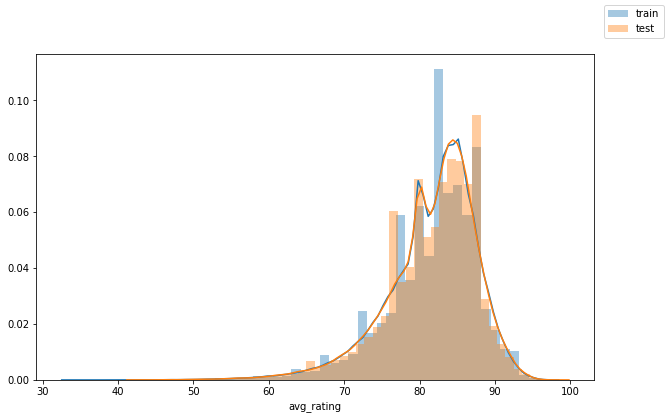

In [12]:
fig = plt.figure(figsize=(10,6))
sns.distplot(train['avg_rating'].dropna())
sns.distplot(test['avg_rating'].dropna())
fig.legend(labels=['train','test'])
plt.show()

The data distribution for the feature **avg_rating** is almost identical for the test set and the train set. Besides, the distribution is relatively close to a normal distribution where mean = median. We could use a median imputation for the missing values. But let's first remove outliers.

### 2.2. Outliers detection

#### 2.2.1. Z-Score

In [13]:
def zscore(series, threshold=3):
    z_score = (series-np.mean(series)) / np.std(series)
    return np.abs(z_score) > threshold

#### 2.2.2. Modified Z-Score

In [14]:
def modified_zscore(series, threshold=3):
    modified_z_score = 0.6745*(series-np.median(series))/series.mad()
    return np.abs(modified_z_score) > threshold

#### 2.2.3. Isolation Forest

In [15]:
from sklearn.ensemble import IsolationForest

In [16]:
def isolation_forest(series):
    clf = IsolationForest(behaviour='new', contamination='auto', random_state=0)
    series = series.values.reshape(-1, 1)
    clf.fit(series)
    return clf.predict(series)

#### Comparing outliers detection techniques

In [17]:
def get_proportion(series, inf, sup):
    return round((len(series[(series > inf) & (series < sup)]) / len(series))*100, 2)

In [18]:
def outlier_print(title, inliers, series):
    print('Outlier detection: {} identified outliers outside of the range [{}, {}]. Resulting outlier proportion: {}%.'.format(title, round(min(inliers)), round(max(inliers)), get_proportion(series, max(inliers), max(series)+1)))

In [19]:
def outliers_detection(series):
    inliers_zscore = series[~zscore(series)]
    outlier_print('Z-Score', inliers_zscore, series)
    inliers_modified_zscore = series[~modified_zscore(series)]
    outlier_print('Modified Z-Score', inliers_modified_zscore, series)
    inliers_isolation_forest = series[isolation_forest(series) == 1]
    outlier_print('Isolation Forest', inliers_isolation_forest, series)

In [20]:
train_numeric_columns = ['content_score', 'n_images', 'distance_to_center', 'avg_rating', 'n_reviews', 'avg_price', 'avg_saving_percent', 'n_clicks']
test_numeric_columns = ['content_score', 'n_images', 'distance_to_center', 'avg_rating', 'n_reviews', 'avg_price', 'avg_saving_percent']

In [21]:
train_without_missing_values = train.dropna()
test_without_missing_values = test.dropna()

In [22]:
print('Train set outliers detection:')
print('='*30)
for column in train_numeric_columns:
    print('⚀ Outlier detection for feature', column, ':\n')
    outliers_detection(train_without_missing_values[column])
    print('-'*120)

Train set outliers detection:
⚀ Outlier detection for feature content_score :

Outlier detection: Z-Score identified outliers outside of the range [28, 81]. Resulting outlier proportion: 0.0%.
Outlier detection: Modified Z-Score identified outliers outside of the range [28, 81]. Resulting outlier proportion: 0.0%.
Outlier detection: Isolation Forest identified outliers outside of the range [48, 63]. Resulting outlier proportion: 10.02%.
------------------------------------------------------------------------------------------------------------------------
⚀ Outlier detection for feature n_images :

Outlier detection: Z-Score identified outliers outside of the range [-1, 59672]. Resulting outlier proportion: 0.08%.
Outlier detection: Modified Z-Score identified outliers outside of the range [-1, 249]. Resulting outlier proportion: 0.09%.
Outlier detection: Isolation Forest identified outliers outside of the range [0, 3]. Resulting outlier proportion: 16.16%.
----------------------------

By definition, if there are too many outliers... they are not outliers. I use the outliers detection technique that is the most permissive : in this case it is Z-Score for every feature. I decide to drop the outliers when the proportion is < 1%.

In [22]:
def drop_outliers_zscore(df, column):
    inliers_zscore = df[column][~zscore(df[column])]
    min_inliers = round(min(inliers_zscore))
    max_inliers = round(max(inliers_zscore))
    outliers_proportion = get_proportion(df[column], max_inliers, max(df[column])+1)
    if outliers_proportion < 1:
        return df[(df[column] >= min_inliers) & (df[column] <= max_inliers)]
    else:
        return df

In [23]:
print('Dropping outliers where outliers proportion < 1% ...')
for column in train_numeric_columns:
    train_without_missing_values = drop_outliers_zscore(train_without_missing_values, column)

Dropping outliers where outliers proportion < 1% ...


In [25]:
print('Test set outliers detection:')
print('='*30)
for column in test_numeric_columns:
    print('⚀ Outlier detection for feature', column, ':\n')
    outliers_detection(test_without_missing_values[column])
    print('-'*120)

Test set outliers detection:
⚀ Outlier detection for feature content_score :

Outlier detection: Z-Score identified outliers outside of the range [28, 80]. Resulting outlier proportion: 0.0%.
Outlier detection: Modified Z-Score identified outliers outside of the range [27, 80]. Resulting outlier proportion: 0.0%.
Outlier detection: Isolation Forest identified outliers outside of the range [48, 63]. Resulting outlier proportion: 10.02%.
------------------------------------------------------------------------------------------------------------------------
⚀ Outlier detection for feature n_images :

Outlier detection: Z-Score identified outliers outside of the range [-1, 72686]. Resulting outlier proportion: 0.06%.
Outlier detection: Modified Z-Score identified outliers outside of the range [-1, 56]. Resulting outlier proportion: 0.1%.
Outlier detection: Isolation Forest identified outliers outside of the range [-1, 3]. Resulting outlier proportion: 15.86%.
------------------------------

In [24]:
print('Dropping outliers where outliers proportion < 1% ...')
for column in test_numeric_columns:
    test_without_missing_values = drop_outliers_zscore(test_without_missing_values, column)

Dropping outliers where outliers proportion < 1% ...


In [25]:
train_missing_values = train[train.isnull().any(axis=1)]
test_missing_values = test[test.isnull().any(axis=1)]

In [26]:
print('Before outliers removal, train set has',len(train),'rows.')
print('Before outliers removal, test set has',len(test),'rows.')

Before outliers removal, train set has 395760 rows.
Before outliers removal, test set has 131929 rows.


In [27]:
train = pd.concat([train_without_missing_values, train_missing_values])
test = pd.concat([test_without_missing_values, test_missing_values])

In [28]:
print('After outliers removal, train set has',len(train),'rows.')
print('After outliers removal, test set has',len(test),'rows.')

After outliers removal, train set has 382308 rows.
After outliers removal, test set has 127991 rows.


### 2.3. Missing values imputation

Now I will impute the missing values for the feature **avg_rating**. 
Let's have a look at the data distribution after outliers removal.

C:\Users\aghenda\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


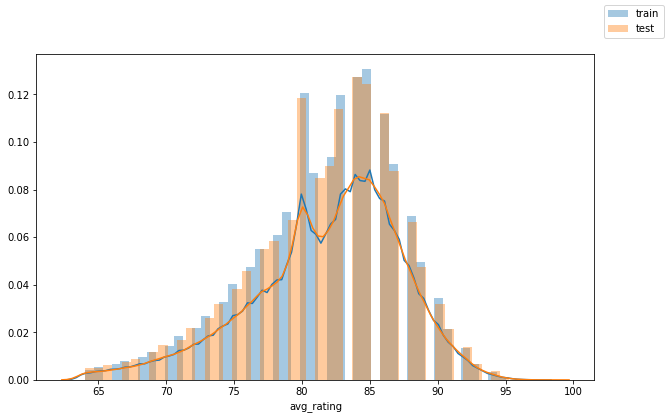

In [29]:
fig = plt.figure(figsize=(10,6))
sns.distplot(train['avg_rating'].dropna())
sns.distplot(test['avg_rating'].dropna())
fig.legend(labels=['train','test'])
plt.show()

For the imputation of missing values, I use k-Nearest Neighbors.

In [51]:
print('Missing values imputation using kNN...')
train = fast_knn(train, k=4)
test = fast_knn(test, k=4)
print('Done.')

Missing values imputation using kNN...
Done.


In [54]:
train_columns = ['hotel_id', 'city_id', 'content_score', 'n_images', 'distnace_to_center', 'avg_rating', 'stars', 'n_reviews', 'avg_rank', 'avg_price', 'avg_saving_percent', 'n_clicks']
test_columns = ['hotel_id', 'city_id', 'content_score', 'n_images', 'distnace_to_center', 'avg_rating', 'stars', 'n_reviews', 'avg_rank', 'avg_price', 'avg_saving_percent']

In [56]:
train.columns = train_columns
test.columns = test_columns

In [59]:
train_columns = list(train.columns)
print('Train data set:\n')
for column in train_columns:
    print('All entries in train set have non-null', column ,':', ~train[column].isnull().any())
    
print('-'*100)

test_columns = list(test.columns)
print('Test data set:\n')
for column in test_columns:
    print('All entries in test set have non-null', column ,':', ~test[column].isnull().any())

Train data set:

All entries in train set have non-null hotel_id : True
All entries in train set have non-null city_id : True
All entries in train set have non-null content_score : True
All entries in train set have non-null n_images : True
All entries in train set have non-null distnace_to_center : True
All entries in train set have non-null avg_rating : True
All entries in train set have non-null stars : True
All entries in train set have non-null n_reviews : True
All entries in train set have non-null avg_rank : True
All entries in train set have non-null avg_price : True
All entries in train set have non-null avg_saving_percent : True
All entries in train set have non-null n_clicks : True
----------------------------------------------------------------------------------------------------
Test data set:

All entries in test set have non-null hotel_id : True
All entries in test set have non-null city_id : True
All entries in test set have non-null content_score : True
All entries in 

No more missing values!

## 3. Exploratory data analysis
<a id="eda"></a>

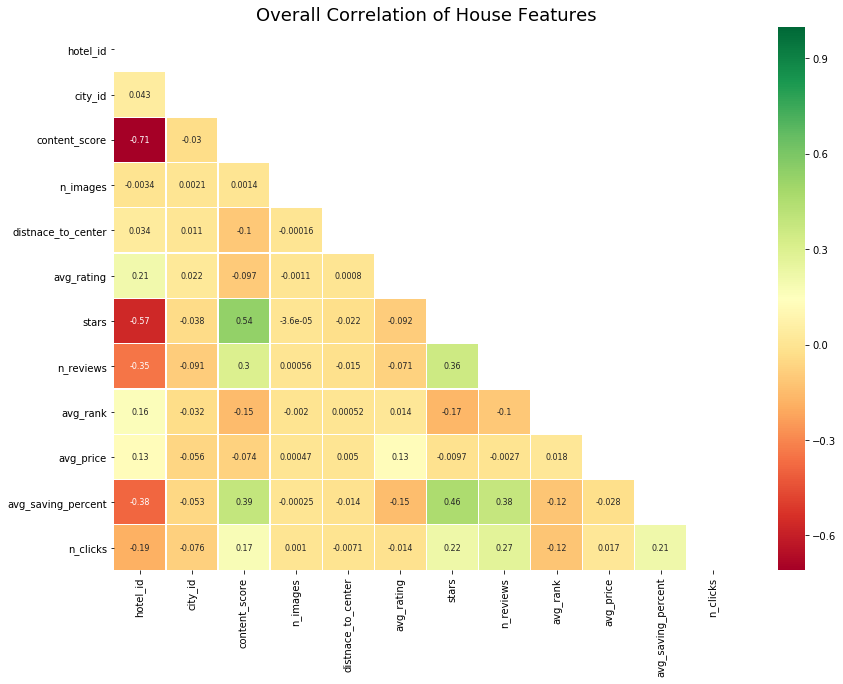

In [80]:
corr = train.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set-up figure
plt.figure(figsize=(14, 10))
# Title
plt.title('Overall Correlation of House Features', fontsize=18)
# Correlation matrix
sns.heatmap(corr, mask=mask, annot=True, annot_kws={"size":8}, cmap='RdYlGn', linewidths=0.2)
plt.show()

**n_reviews**, **stars**, **avg_saving_percent** and **content_score** are the features that are the most correlated to **n_clicks**.

### 3.1. Bivariate analysis

C:\Users\aghenda\AppData\Roaming\Python\Python37\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


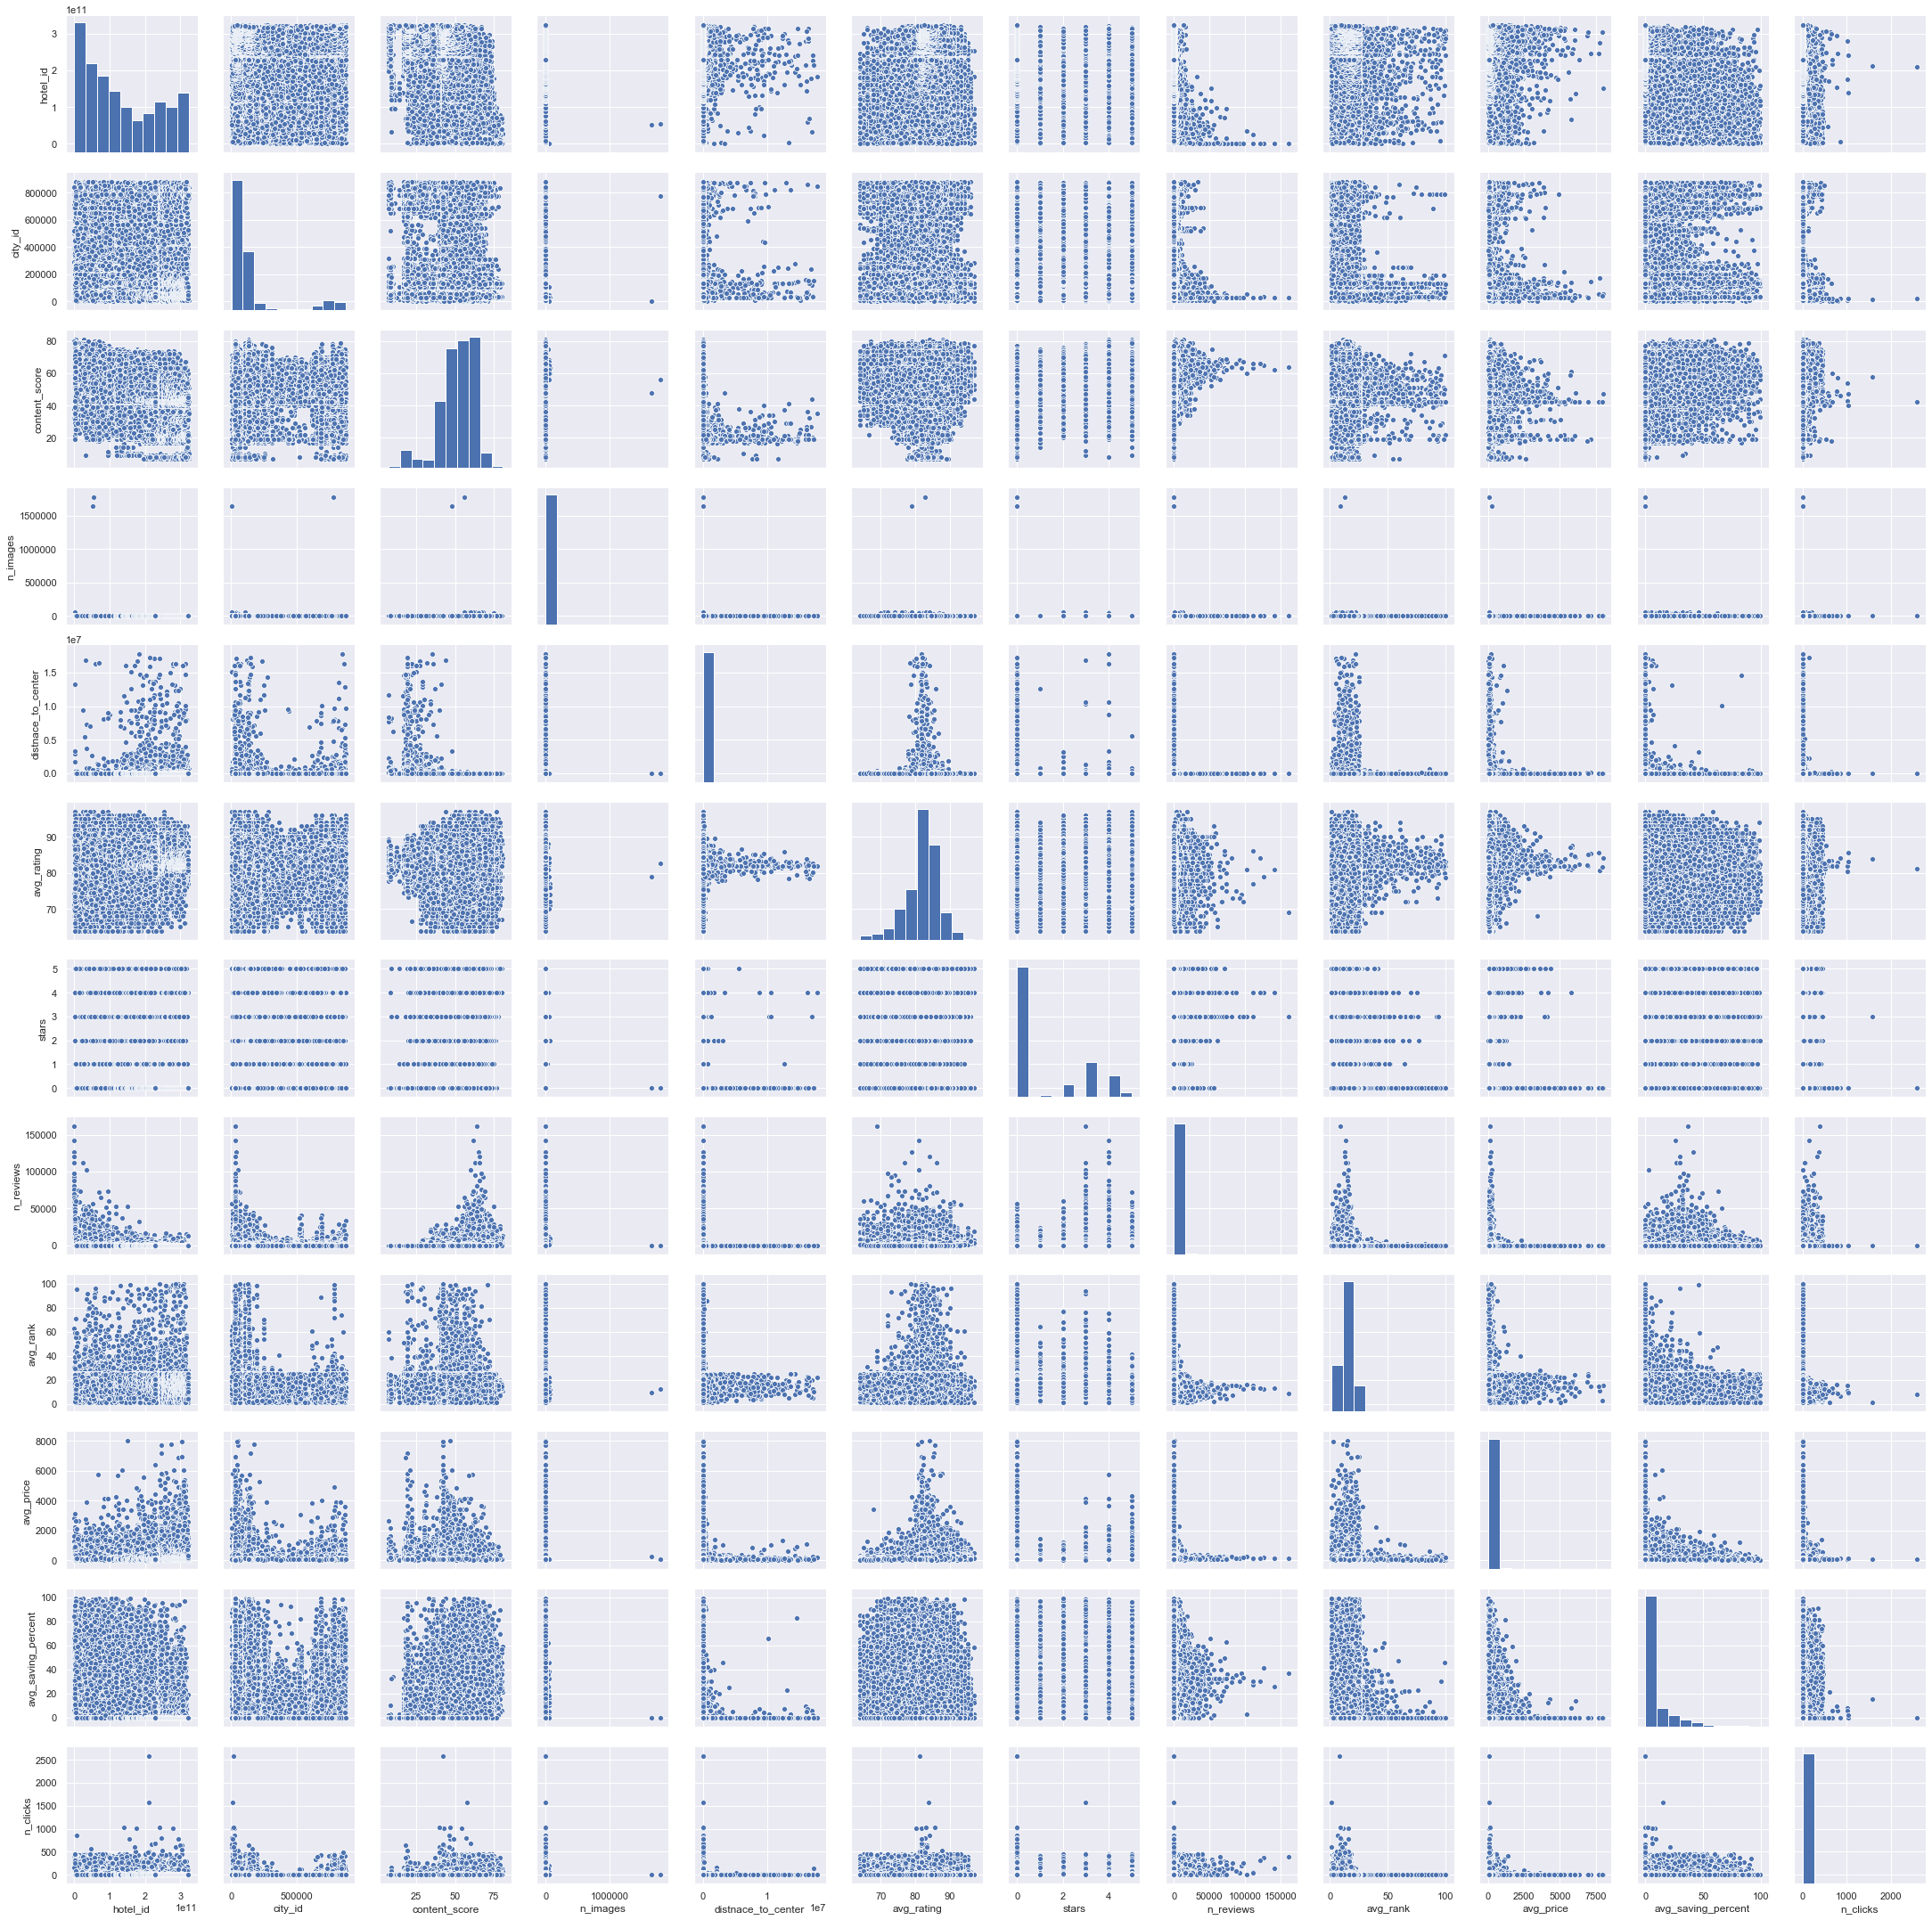

In [81]:
#scatterplot
sns.set()
columns = list(train.columns)
sns.pairplot(train[columns], size = 2.5)
plt.show();

## 4. Prediction
<a id="pred"></a>

## 5. Evaluation
<a id="eval"></a>

## 6. Conclusion
<a id="conc"></a>